In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Connection string
db_connection_string = "your-connection-string"

# Create the engine
try:
    engine = create_engine(db_connection_string)
    print("Database connection successful.")
except Exception as e:
    print(f"Error connecting to the database: {e}")

# SQL query to fetch property-level data with enhanced competitor metrics
# SQL query to fetch property-level data with enhanced competitor metrics
query_property = """
SELECT 
    p.property_id,
    p.latitude,
    p.longitude,
    p.square_foot,
    p.price_per_sqft,
    p.size_category,
    cat.category_name AS property_category,  -- Category encoding
    t.total_aadt,
    t.foot_traffic_proxy,
    t.combined_traffic_accessibility,
    d.total_population,
    d.population_density,
    d.median_household_income,
    d.total_spending_adjusted AS demographic_spending,
    d.housing_adjusted AS demographic_housing_spending,
    d.food_and_beverages_adjusted AS demographic_food_spending,
    d.healthcare_adjusted AS demographic_healthcare_spending,
    d.gas_and_energy_adjusted AS demographic_energy_spending,
    COUNT(c.competitor_id) AS competitor_count,  -- Competitor count
    AVG(c.rating) AS avg_competitor_rating,  -- Average competitor ratings
    AVG(c.aggregate_sentiment) AS avg_competitor_sentiment,  -- Average sentiment scores
    AVG(c.business_age) AS avg_competitor_age,  -- Average competitor age
    AVG(c.weighted_rating) AS avg_competitor_weighted_rating  -- Average weighted rating
FROM dim_properties p
LEFT JOIN dim_traffic t ON p.traffic_id = t.traffic_id
LEFT JOIN dim_demographics d ON p.demographic_id = d.demographic_id
LEFT JOIN competitors c ON p.property_id = c.property_id
LEFT JOIN categories cat ON p.category_id = cat.category_id
GROUP BY p.property_id, p.latitude, p.longitude, p.square_foot, 
         p.price_per_sqft, p.size_category, cat.category_name,
         t.total_aadt, t.foot_traffic_proxy, t.combined_traffic_accessibility,
         d.total_population, d.population_density, d.median_household_income,
         d.total_spending_adjusted, d.housing_adjusted, 
         d.food_and_beverages_adjusted, d.healthcare_adjusted, 
         d.gas_and_energy_adjusted
"""


# Execute the query and load the data
try:
    property_data = pd.read_sql(query_property, engine)
    print("Property data loaded successfully. Here are the first few rows:")
    print(property_data.head())
except Exception as e:
    print(f"Error loading property data: {e}")


Database connection successful.
Property data loaded successfully. Here are the first few rows:
   property_id   latitude   longitude  square_foot  price_per_sqft  \
0          366  37.926987 -122.385284         5000          390.00   
1          354  37.408855 -121.994385        20377          520.19   
2          532  37.804157 -122.415268         9404          691.20   
3          386  37.772053 -122.223488         5673          211.53   
4           12  37.576065 -121.977234         2634          378.89   

  size_category property_category  total_aadt  foot_traffic_proxy  \
0        Medium            office    144000.0            0.711788   
1         Large            retail    167000.0            0.613521   
2         Large            retail     75500.0            0.502847   
3         Large        restaurant    134990.0            0.760615   
4         Small            retail     36600.0            0.935827   

   combined_traffic_accessibility  ...  demographic_spending  \
0   

In [2]:
# Add binary feature for presence of competitors
property_data['has_competitors'] = property_data['competitor_count'].apply(lambda x: 1 if x > 0 else 0)

# Handle missing values
property_data['competitor_count'].fillna(0, inplace=True)
property_data['avg_competitor_rating'].fillna(0, inplace=True)
property_data['avg_competitor_sentiment'].fillna(0, inplace=True)
property_data['avg_competitor_age'].fillna(0, inplace=True)

# Verify missing values
print("Missing values after handling competitors:")
print(property_data.isnull().sum())


Missing values after handling competitors:
property_id                         0
latitude                            0
longitude                           0
square_foot                         0
price_per_sqft                      0
size_category                       0
property_category                   0
total_aadt                          0
foot_traffic_proxy                  0
combined_traffic_accessibility      0
total_population                    0
population_density                  0
median_household_income             0
demographic_spending                0
demographic_housing_spending        0
demographic_food_spending           0
demographic_healthcare_spending     0
demographic_energy_spending         0
competitor_count                    0
avg_competitor_rating               0
avg_competitor_sentiment            0
avg_competitor_age                  0
avg_competitor_weighted_rating     16
has_competitors                     0
dtype: int64


/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/4204762419.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  property_data['competitor_count'].fillna(0, inplace=True)
/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/4204762419.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [3]:
# Check the distribution of properties with and without competitors
print("Properties with and without competitors:")
print(property_data['has_competitors'].value_counts())


Properties with and without competitors:
has_competitors
1    525
0     16
Name: count, dtype: int64


In [4]:
# Required imports
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np

# Step 1: Define Spending Adjustments Based on Category
category_to_spending = {
    'restaurant': 'demographic_food_spending',
    'retail': 'demographic_spending',
    'services': 'demographic_healthcare_spending',
    'mixed use': 'demographic_housing_spending',
    'office': 'demographic_energy_spending'
}

# Map category name to property data
property_data['spending_adjusted'] = property_data.apply(
    lambda row: row[category_to_spending[row['property_category']]] 
    if row['property_category'] in category_to_spending else np.nan, axis=1
)

# Step 2: Create Derived Features
property_data['spending_per_capita'] = property_data['spending_adjusted'] / (property_data['total_population'] + 1)
property_data['traffic_weighted_spending'] = property_data['spending_adjusted'] * property_data['foot_traffic_proxy']

# Step 3: Encode Property Categories
property_data['business_type_encoded'] = LabelEncoder().fit_transform(property_data['property_category'])

# Step 4: Check for Missing Values and Handle Them
# Fill missing values if any
property_data['spending_per_capita'].fillna(0, inplace=True)
property_data['traffic_weighted_spending'].fillna(0, inplace=True)
property_data['spending_adjusted'].fillna(0, inplace=True)

# Step 5: Scale Features
# Select features that require scaling
features_to_scale = ['spending_adjusted', 'median_household_income', 
                     'total_aadt', 'population_density', 
                     'spending_per_capita', 'traffic_weighted_spending']

scaler = MinMaxScaler()
property_data[features_to_scale] = scaler.fit_transform(property_data[features_to_scale])

# Step 6: Finalize Features for Model Input
final_features = [
    'foot_traffic_proxy', 
    'spending_adjusted', 
    'median_household_income', 
    'total_aadt', 
    'business_type_encoded', 
    'population_density', 
    'competitor_count', 
    'spending_per_capita', 
    'traffic_weighted_spending'
]

# Extract transformed data for predictions
X_property = property_data[final_features]

# Step 7: Verify Prepared Data
print("Transformed Property Data for Model Input:")
print(X_property.head())


Transformed Property Data for Model Input:
   foot_traffic_proxy  spending_adjusted  median_household_income  total_aadt  \
0            0.711788           0.006418                 0.411213    0.244719   
1            0.613521           0.497662                 0.410381    0.287717   
2            0.502847           0.144166                 0.309006    0.116657   
3            0.760615           0.019546                 0.225822    0.227874   
4            0.935827           0.771208                 0.489540    0.043933   

   business_type_encoded  population_density  competitor_count  \
0                      1            0.002137                17   
1                      3            0.053198                17   
2                      3            0.453979                20   
3                      2            0.046139                20   
4                      3            0.039377                17   

   spending_per_capita  traffic_weighted_spending  
0             0.00847

/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/2579650124.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  property_data['spending_per_capita'].fillna(0, inplace=True)
/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/2579650124.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [5]:
# Import required libraries
import pandas as pd
import joblib

# Step 1: Load the trained model
model_file_path = "gradient_competitor_model.pkl"  
model = joblib.load(model_file_path)
print("Trained model loaded successfully.")

# Step 2: Ensure the features match the training set
final_features = [
    'foot_traffic_proxy', 
    'spending_adjusted', 
    'median_household_income', 
    'total_aadt', 
    'business_type_encoded', 
    'population_density', 
    'competitor_count', 
    'spending_per_capita', 
    'traffic_weighted_spending'
]

# Verify if all features are available in the property data
missing_features = [feature for feature in final_features if feature not in property_data.columns]
if missing_features:
    print(f"Missing features in property data: {missing_features}")
    raise ValueError("Property data is missing required features!")
else:
    print("All required features are available.")

# Step 3: Use scaled features for predictions
X_property = property_data[final_features]

# Step 4: Make predictions
property_predictions = model.predict(X_property)

# Step 5: Display raw predictions
print("Raw Predictions (Numerical Classes):")
print(property_predictions[:10])  # Display first 10 predictions


Trained model loaded successfully.
All required features are available.
Raw Predictions (Numerical Classes):
['Successful' 'Not Successful' 'Successful' 'Potential' 'Potential'
 'Not Successful' 'Not Successful' 'Not Successful' 'Not Successful'
 'Not Successful']


In [6]:
# Combine property IDs with predictions
property_data['success_category_predicted'] = property_predictions

# Display Property IDs along with Predictions
predicted_results = property_data[['property_id', 'success_category_predicted']]

# Display first few results
print(predicted_results.head(10))


   property_id success_category_predicted
0          366                 Successful
1          354             Not Successful
2          532                 Successful
3          386                  Potential
4           12                  Potential
5           62             Not Successful
6          516             Not Successful
7          176             Not Successful
8          162             Not Successful
9          303             Not Successful


In [10]:

# Count the occurrences of each success category
category_counts = property_data['success_category_predicted'].value_counts()

# Display the counts
print("Success Category Counts:")
print(category_counts)


Success Category Counts:
success_category_predicted
Not Successful    236
Potential         153
Successful        152
Name: count, dtype: int64


In [12]:

# Get prediction probabilities
property_probabilities = model.predict_proba(X_property)

# Add probabilities to the DataFrame (optional step for insights)
property_data['not_successful_prob'] = property_probabilities[:, 0]

property_data['potential_prob'] = property_probabilities[:, 1]
property_data['successful_prob'] = property_probabilities[:, 2]

# Display probabilities
print("Property-Level Predictions with Confidence Scores:")
print(property_data[['property_id', 'success_category_predicted', 'not_successful_prob', 
                     'potential_prob', 'successful_prob']].head())


Property-Level Predictions with Confidence Scores:
   property_id success_category_predicted  not_successful_prob  \
0          366                 Successful             0.182198   
1          354             Not Successful             0.753657   
2          532                 Successful             0.178640   
3          386                  Potential             0.268484   
4           12                  Potential             0.387831   

   potential_prob  successful_prob  
0        0.079581         0.738220  
1        0.204118         0.042224  
2        0.150392         0.670968  
3        0.472912         0.258604  
4        0.559276         0.052893  


Feature Importances successfully extracted.
Feature Importance Matrix:
                     Feature  Importance
0         foot_traffic_proxy    0.225271
4      business_type_encoded    0.178241
8  traffic_weighted_spending    0.175633
5         population_density    0.103663
3                 total_aadt    0.096688
2    median_household_income    0.082484
6           competitor_count    0.052739
7        spending_per_capita    0.043131
1          spending_adjusted    0.042151


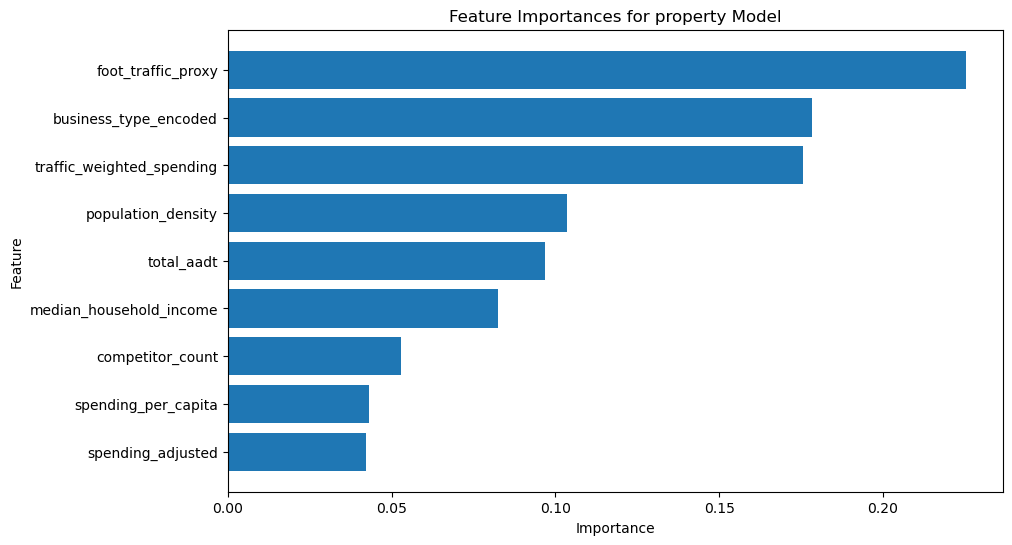

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Verify if the model has feature importances
if hasattr(model, "feature_importances_"):
    feature_importances = model.feature_importances_
    print("Feature Importances successfully extracted.")
else:
    raise ValueError("The loaded model does not support feature importances directly.")

# Step 2: Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': final_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Step 3: Print the importance matrix
print("Feature Importance Matrix:")
print(importance_df)

# Step 4: Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for property Model')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [18]:
# Avoid division by zero in population density
property_data['estimated_area_sq_km'] = property_data['total_population'] / property_data['population_density']
property_data['estimated_area_sq_km'].replace([np.inf, -np.inf], 0, inplace=True)
property_data['estimated_area_sq_km'].fillna(0, inplace=True)


/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/794076065.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  property_data['estimated_area_sq_km'].replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/794076065.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [20]:
# Competitor Density in competitors per square kilometer
property_data['competitor_density'] = property_data['competitor_count'] / property_data['estimated_area_sq_km']
property_data['competitor_density'].replace([np.inf, -np.inf], 0, inplace=True)
property_data['competitor_density'].fillna(0, inplace=True)
# Scale competitor density to competitors per 10,000 sq_m (hectares)
scale_factor = 1000 # Adjust as needed
property_data['competitor_density'] = property_data['competitor_density'] * scale_factor
# Summary statistics of scaled density
print("Competitor Density (Scaled):")
print(property_data['competitor_density'].describe())



Competitor Density (Scaled):
count    541.000000
mean       0.460761
std        1.031763
min        0.000000
25%        0.061334
50%        0.207446
75%        0.365517
max       10.765639
Name: competitor_density, dtype: float64


/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/2936298846.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  property_data['competitor_density'].replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/2936298846.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

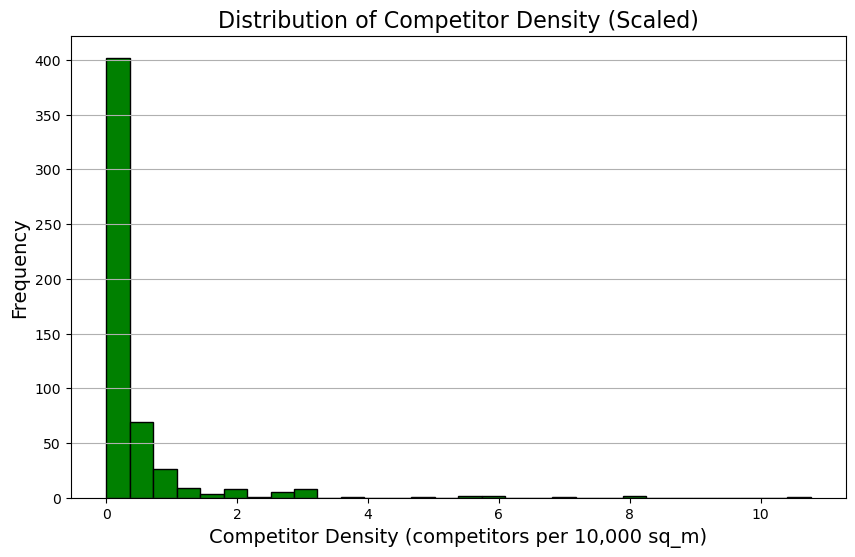

In [25]:
import matplotlib.pyplot as plt

# Competitor Density Distribution (Scaled)
plt.figure(figsize=(10, 6))
property_data['competitor_density'].plot(kind='hist', bins=30, color='green', edgecolor='black')
plt.title('Distribution of Competitor Density (Scaled)', fontsize=16)
plt.xlabel('Competitor Density (competitors per 10,000 sq_m)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y')
plt.show()


In [134]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Select features to normalize
features_to_scale = [
    'total_aadt', 'median_household_income',
    'spending_adjusted', 'avg_competitor_sentiment',
    'competitor_density','median_household_income', 'avg_competitor_age'
]

# Normalize features
property_data[features_to_scale] = scaler.fit_transform(property_data[features_to_scale])


In [54]:
# Normalize feature importances
importance_df['Normalized_Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# Map normalized importance values to a dictionary for easy access
importance_weights = dict(zip(importance_df['Feature'], importance_df['Normalized_Importance']))

print("Normalized Feature Importances:")
print(importance_weights)


Normalized Feature Importances:
{'foot_traffic_proxy': 0.2252707098475287, 'business_type_encoded': 0.17824148856282301, 'traffic_weighted_spending': 0.17563339835438552, 'population_density': 0.1036626793098061, 'total_aadt': 0.09668750751713404, 'median_household_income': 0.08248373982182562, 'competitor_count': 0.05273885458012732, 'spending_per_capita': 0.04313084360168525, 'spending_adjusted': 0.04215077840468434}


In [106]:
# Market Saturation Index
property_data['market_saturation_index'] = 10*(
    property_data['competitor_density'] * (1 - property_data['avg_competitor_sentiment'])
)


In [164]:
import numpy as np

# Transform total_aadt and foot_traffic_proxy into a single metric
property_data['transformed_traffic'] = np.log1p(property_data['total_aadt']) * property_data['foot_traffic_proxy']

# Business Suitability Score (BSS)
property_data['business_score'] = (
    property_data['successful_prob'] * (
        0.3 * (1 / np.log1p(property_data['price_per_sqft'])) +  # Apply log transformation
        0.25 * property_data['avg_competitor_weighted_rating'] +
        0.2 * property_data['competitor_count'] +
        0.15 * (1 - property_data['market_saturation_index']) +
        0.1 * property_data['transformed_traffic']
    )
)

# Longevity Score (Updated without business_age)
property_data['longevity_score_raw'] = (
    property_data['successful_prob'] * (
        0.4 * property_data['avg_competitor_age'] +
        0.3 * (1 - property_data['market_saturation_index']) +
        0.2 * property_data['median_household_income'] +
        0.1 * property_data['transformed_traffic']
    )
)

# Display the updated Longevity Score
print("Updated Longevity Score:")
print(property_data[['property_id', 'longevity_score']].head())

# Define additional category-related features and normalize them
property_data['normalized_sentiment'] = property_data['avg_competitor_sentiment'] / property_data['avg_competitor_sentiment'].max()
property_data['normalized_competitor_count'] = property_data['competitor_count'] / property_data['competitor_count'].max()

# Calculate raw Category Fit Score
property_data['raw_category_fit_score'] = (
    importance_weights['business_type_encoded'] * property_data['spending_adjusted'] +
    0.3 * property_data['normalized_sentiment'] +  # Sentiment weight
    0.2 * property_data['normalized_competitor_count']  # Competitor count weight
)

# Scale the score to range from 1 to 10
property_data['category_fit_score'] = (
    1 + (property_data['raw_category_fit_score'] - property_data['raw_category_fit_score'].min()) /
        (property_data['raw_category_fit_score'].max() - property_data['raw_category_fit_score'].min()) * 9
)


# Display calculated scores
print("Calculated Scores:")
print(property_data[['property_id', 'business_score', 'longevity_score_raw', 'category_fit_score']].head())

Updated Longevity Score:
   property_id  longevity_score
0          366         9.586676
1          354         8.918607
2          532         7.188768
3          386         8.994526
4           12         8.937688
Calculated Scores:
   property_id  business_score  longevity_score_raw  category_fit_score
0          366        3.383415             0.440257            5.737539
1          354        0.192013             0.024307            6.618943
2          532        3.481821             0.152599            8.491277
3          386        1.350048             0.135948            5.437053
4           12        0.246211             0.030270            8.701069


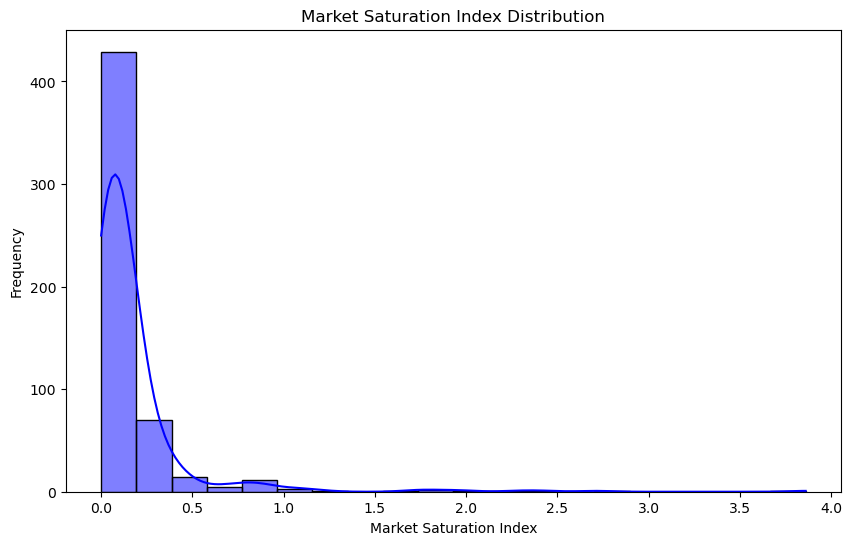

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

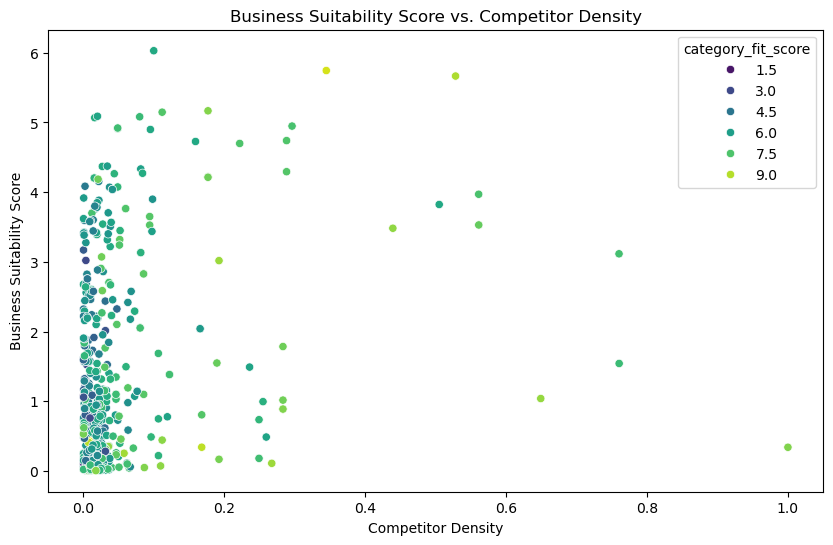

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

# Market Saturation Index Distribution
plt.figure(figsize=(10, 6))
sns.histplot(property_data['market_saturation_index'], bins=20, kde=True, color='blue')
plt.title('Market Saturation Index Distribution')
plt.xlabel('Market Saturation Index')
plt.ylabel('Frequency')
plt.show()

# Business Suitability Score (BSS) vs. Competitor Density
plt.figure(figsize=(10, 6))
sns.scatterplot(x=property_data['competitor_density'], y=property_data['business_score'], hue=property_data['category_fit_score'], palette='viridis')
plt.title('Business Suitability Score vs. Competitor Density')
plt.xlabel('Competitor Density')
plt.ylabel('Business Suitability Score')
plt.colorbar(label='Category Fit Score')
plt.show()




In [170]:
import folium
from folium.plugins import HeatMap

# Prepare data for heatmap
heatmap_data = property_data[['latitude', 'longitude', 'business_score']].dropna()

# Initialize map centered around the data's mean coordinates
m = folium.Map(location=[heatmap_data['latitude'].mean(), heatmap_data['longitude'].mean()], zoom_start=10)

# Add heatmap layer
HeatMap(
    data=heatmap_data[['latitude', 'longitude', 'business_score']].values.tolist(),
    radius=10
).add_to(m)

# Display the map
m


In [104]:
# Scale Business Suitability Score (BSS) to range 1-100
property_data['business_suitability_score'] = (
    1 + (property_data['business_score'] - property_data['business_score'].min()) /
        (property_data['business_scorebusiness_score'].max() - property_data['business_score'].min()) * 99
)

# Scale Longevity Score to range 1-10
property_data['longevity_score'] = (
    1 + (property_data['longevity_score_raw'] - property_data['longevity_score_raw'].min()) /
        (property_data['longevity_score_raw'].max() - property_data['longevity_score_raw'].min()) * 9
)

# Display the updated scores
print("Scaled Scores:")
print(property_data[['property_id', 'business_suitability_score_scaled', 'longevity_score', 'category_fit_score']].head())


Scaled Scores:
   property_id  business_suitability_score  longevity_score  \
0          366                   63.613653         9.586676   
1          354                    4.391181         8.918607   
2          532                   54.190612         7.188768   
3          386                   25.278847         8.994526   
4           12                    5.452020         8.937688   

   category_fit_score  
0            5.737539  
1            6.618943  
2            8.491277  
3            5.437053  
4            8.701069  


In [84]:
# Group metrics by predicted success labels
proxy_validation = property_data.groupby('success_category_predicted').agg({
    'business_suitability_score': 'mean',
    'longevity_score': 'mean',
    'market_saturation_index': 'mean'
}).reset_index()

print(proxy_validation)

  success_category_predicted  business_suitability_score  longevity_score  \
0             Not Successful                    8.534726         3.748924   
1                  Potential                   13.322809         4.029848   
2                 Successful                   52.513986         6.450576   

   market_saturation_index  
0                 0.143848  
1                 0.157836  
2                 0.221103  


In [90]:
import numpy as np

# Define weights for the features
w1, w2, w3, w4 = 0.4, 0.3, 0.2, 0.1

# Step 1: Calculate raw expected foot traffic
property_data['raw_expected_foot_traffic'] = (
    w1 * property_data['foot_traffic_proxy'] + 
    w2 * np.log1p(property_data['total_aadt']) + 
    w3 * property_data['population_density'] + 
    w4 * property_data['competitor_count']
)

# Step 2: Scale to range 1-100
property_data['expected_foot_traffic_score'] = (
    1 + (property_data['raw_expected_foot_traffic'] - property_data['raw_expected_foot_traffic'].min()) /
        (property_data['raw_expected_foot_traffic'].max() - property_data['raw_expected_foot_traffic'].min()) * 99
)

# Display the scaled expected foot traffic
print("Scaled Expected Foot Traffic:")
print(property_data[['property_id', 'expected_foot_traffic_score']].head())


Scaled Expected Foot Traffic:
   property_id  expected_foot_traffic_score
0          366                    44.687419
1          354                    44.223743
2          532                    51.412614
3          386                    52.639408
4           12                    45.773599


In [94]:
from datetime import datetime

# Map predicted labels to their corresponding probability columns

label_to_prob_map = {
    'Successful': 'successful_prob',
    'Potential': 'potential_prob',
    'Not Successful': 'not_successful_prob'
}

# Calculate the probability of the predicted label
property_data['prob_of_predicted_label'] = property_data.apply(
    lambda row: row[label_to_prob_map[row['success_category_predicted']]], axis=1
)

# Prepare the data for the fact table
fact_table_data = property_data[[
    'property_id',
    'business_suitability_score',  # Scaled BSS
    'expected_foot_traffic',      # Scaled Expected Foot Traffic
    'longevity_score',            # Scaled Longevity Score
    'category_fit_score',                # Category Fit Score
    'prob_of_predicted_label',           # Probability of predicted label
    'competitor_count',                  # Competitor count
    'market_saturation_index',           # Market Saturation Index
    'avg_competitor_sentiment'           # Average competitor sentiment
]]


# Add additional columns for demographic_id, traffic_id, created_at, and updated_at
fact_table_data['demographic_id'] = None  # Placeholder for demographic_id
fact_table_data['traffic_id'] = None      # Placeholder for traffic_id
fact_table_data['success_prediction'] = property_data['success_category_predicted']  # Success label
fact_table_data['created_at'] = datetime.now()  # Current timestamp
fact_table_data['updated_at'] = datetime.now()  # Current timestamp

# Display a preview of the prepared data
print("Prepared Fact Table Data:")
print(fact_table_data.head())


Prepared Fact Table Data:
   property_id  business_suitability_score  expected_foot_traffic  \
0          366                   56.538129              44.687419   
1          354                    4.098782              44.223743   
2          532                   58.155086              51.412614   
3          386                   23.126972              52.639408   
4           12                    4.989324              45.773599   

   longevity_score  category_fit_score  prob_of_predicted_label  \
0         7.533106            5.737539                 0.738220   
1         3.478345            6.618943                 0.753657   
2         4.728959            8.491277                 0.670968   
3         4.566642            5.437053                 0.472912   
4         3.536472            8.701069                 0.559276   

   competitor_count  market_saturation_index  avg_competitor_sentiment  \
0                17                 0.004827                  0.511985   
1       

/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/184729909.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_table_data['demographic_id'] = None  # Placeholder for demographic_id
/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/184729909.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_table_data['traffic_id'] = None      # Placeholder for traffic_id
/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_54526/184729909.py:33: SettingWithCopyWarning: 
A v

In [96]:
# Fetch dim_properties data
dim_properties_query = """
SELECT property_id, demographic_id, traffic_id
FROM dim_properties;
"""
dim_properties = pd.read_sql(dim_properties_query, con=engine)  # Fetch data from the database

# Merge the data
fact_table_data = fact_table_data.merge(dim_properties, on='property_id', how='left')

# Verify the merged data
print("Fact Table Data After Adding demographic_id and traffic_id:")
print(fact_table_data.head())


Fact Table Data After Adding demographic_id and traffic_id:
   property_id  business_suitability_score  expected_foot_traffic  \
0          366                   56.538129              44.687419   
1          354                    4.098782              44.223743   
2          532                   58.155086              51.412614   
3          386                   23.126972              52.639408   
4           12                    4.989324              45.773599   

   longevity_score  category_fit_score  prob_of_predicted_label  \
0         7.533106            5.737539                 0.738220   
1         3.478345            6.618943                 0.753657   
2         4.728959            8.491277                 0.670968   
3         4.566642            5.437053                 0.472912   
4         3.536472            8.701069                 0.559276   

   competitor_count  market_saturation_index  avg_competitor_sentiment  \
0                17                 0.004827    

In [98]:
# Drop the old placeholder columns
fact_table_data.drop(columns=['demographic_id_x', 'traffic_id_x'], inplace=True)

# Rename the new columns to match the schema
fact_table_data.rename(columns={
    'demographic_id_y': 'demographic_id',
    'traffic_id_y': 'traffic_id'
}, inplace=True)

# Verify the final structure of the fact table data
print("Final Fact Table Data:")
print(fact_table_data.head())


Final Fact Table Data:
   property_id  business_suitability_score  expected_foot_traffic  \
0          366                   56.538129              44.687419   
1          354                    4.098782              44.223743   
2          532                   58.155086              51.412614   
3          386                   23.126972              52.639408   
4           12                    4.989324              45.773599   

   longevity_score  category_fit_score  prob_of_predicted_label  \
0         7.533106            5.737539                 0.738220   
1         3.478345            6.618943                 0.753657   
2         4.728959            8.491277                 0.670968   
3         4.566642            5.437053                 0.472912   
4         3.536472            8.701069                 0.559276   

   competitor_count  market_saturation_index  avg_competitor_sentiment  \
0                17                 0.004827                  0.511985   
1          

In [116]:
from datetime import datetime
import numpy as np

# Filter properties where competitor_count = 0
affected_properties = property_data[property_data['competitor_count'] == 0].copy()

# Recalculate Business Suitability Score (renamed for clarity)
affected_properties['recalc_business_suitability_score'] = (
    0.4 * (1 / np.log1p(affected_properties['price_per_sqft'])) +  # Lower price is better
    0.3 * affected_properties['median_household_income'] +         # Income level
    0.3 * affected_properties['foot_traffic_proxy']                # Traffic proxy
) * 100

# Recalculate Longevity Score (renamed for clarity)
affected_properties['recalc_longevity_score'] = (
    0.5 * affected_properties['median_household_income'] +         # Income level
    0.3 * affected_properties['foot_traffic_proxy'] +              # Traffic proxy
    0.2 * affected_properties['total_aadt']                        # Vehicle traffic
) * 10

# Recalculate Category Fit Score (renamed for clarity)
affected_properties['recalc_category_fit_score'] = (
    0.5 * affected_properties['spending_adjusted'] +               # Adjusted spending
    0.3 * affected_properties['foot_traffic_proxy'] +              # Traffic proxy
    0.2 * affected_properties['median_household_income']           # Income level
)

# Recalculate Market Saturation Index (renamed for clarity)
affected_properties['recalc_market_saturation_index'] = 10*(
    0.5 * affected_properties['population_density'] +
    0.5 * affected_properties['spending_adjusted']
)

# Scale Business Suitability Score and Longevity Score (ensure proper range)
affected_properties['recalc_business_suitability_score'] = (
    affected_properties['recalc_business_suitability_score'].clip(lower=1, upper=100)
)
affected_properties['recalc_longevity_score'] = (
    affected_properties['recalc_longevity_score'].clip(lower=1, upper=10)
)

# Ensure Category Fit Score is within 1-10 range
affected_properties['recalc_category_fit_score'] = (
    affected_properties['recalc_category_fit_score']
    .clip(lower=1, upper=10)
)

# Add timestamps for updated_at
affected_properties['updated_at'] = datetime.now()

# Verify the recalculated scores
print("Recalculated Scores for Affected Properties:")
print(affected_properties[[
    'property_id', 'recalc_business_suitability_score', 'recalc_longevity_score',
    'recalc_category_fit_score', 'recalc_market_saturation_index'
]].head())

Recalculated Scores for Affected Properties:
     property_id  recalc_business_suitability_score  recalc_longevity_score  \
14           143                          44.050509                5.487149   
84           372                          42.261852                4.609043   
112          139                          42.862237                4.756360   
119          535                          36.969885                4.726813   
167          507                          30.630344                3.231123   

     recalc_category_fit_score  recalc_market_saturation_index  
14                         1.0                        0.069577  
84                         1.0                        0.175700  
112                        1.0                        0.581347  
119                        1.0                        0.039874  
167                        1.0                        0.017250  


In [118]:
# Check raw scores before scaling
affected_properties['raw_category_fit_score'] = (
    0.5 * affected_properties['spending_adjusted'] +
    0.3 * affected_properties['foot_traffic_proxy'] +
    0.2 * affected_properties['median_household_income']
)

print("Raw Category Fit Scores Before Scaling:")
print(affected_properties[['property_id', 'raw_category_fit_score']].head())


Raw Category Fit Scores Before Scaling:
     property_id  raw_category_fit_score
14           143                0.329545
84           372                0.329177
112          139                0.368036
119          535                0.284122
167          507                0.243958


In [161]:
from datetime import datetime
import numpy as np

# Filter properties where competitor_count = 0
affected_properties = property_data[property_data['competitor_count'] == 0].copy()

# Step 1: Recalculate Raw Scores with population density and available features
affected_properties['raw_business_suitability_score'] = (
    0.35 * (1 / np.log1p(affected_properties['price_per_sqft'])) +  # Lower price is better
    0.25 * affected_properties['median_household_income'] +         # Income level
    0.2 * affected_properties['foot_traffic_proxy'] +               # Traffic proxy
    0.2 * affected_properties['population_density']                 # Population density
)*100

affected_properties['raw_longevity_score'] = (
    0.4 * affected_properties['median_household_income'] +          # Income level
    0.3 * affected_properties['foot_traffic_proxy'] +               # Traffic proxy
    0.2 * affected_properties['total_aadt'] +                       # Vehicle traffic
    0.1 * affected_properties['population_density']                 # Population density
)*10

affected_properties['raw_category_fit_score'] = (
    0.4 * affected_properties['spending_adjusted'] +                # Adjusted spending
    0.3 * affected_properties['foot_traffic_proxy'] +               # Traffic proxy
    0.2 * affected_properties['median_household_income'] +          # Income level
    0.1 * affected_properties['population_density']                 # Population density
)*10

affected_properties['raw_market_saturation_index'] =   (
    0.5 * affected_properties['population_density'] +
    0.5 * affected_properties['spending_adjusted']
)

# Verify raw calculations
print("Raw Scores for Affected Properties:")
print(affected_properties[[
    'property_id', 'raw_business_suitability_score', 'raw_longevity_score',
    'raw_category_fit_score', 'raw_market_saturation_index'
]])


Raw Scores for Affected Properties:
     property_id  raw_business_suitability_score  raw_longevity_score  \
14           143                       33.371497             4.966109   
84           372                       31.596652             4.232895   
112          139                       32.603729             4.281622   
119          535                       27.408468             4.420954   
167          507                       22.093034             3.115233   
233          242                       36.032020             4.149580   
236          415                       34.100862             6.527967   
239          259                       27.408468             4.420954   
266          411                       31.596652             4.232895   
302          398                       39.274026             4.961698   
353          376                       34.691126             6.527967   
364          309                       34.942274             6.527967   
385           1